# Scenario B: The Obstacle Course

Goal: Go from origin to $(2.5, 2.5)$.
Constraint: Pass through midpoint $(2.6, 1)$.
Variable Start: $y$ position is flexible near origin. We will try $y=0$ first.

In [3]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

import numpy as np
import matplotlib.pyplot as plt
from surfaces import ScenarioB
from physics import PhysicsEngine
from solver import ShootingSolver
from utils import plot_trajectory

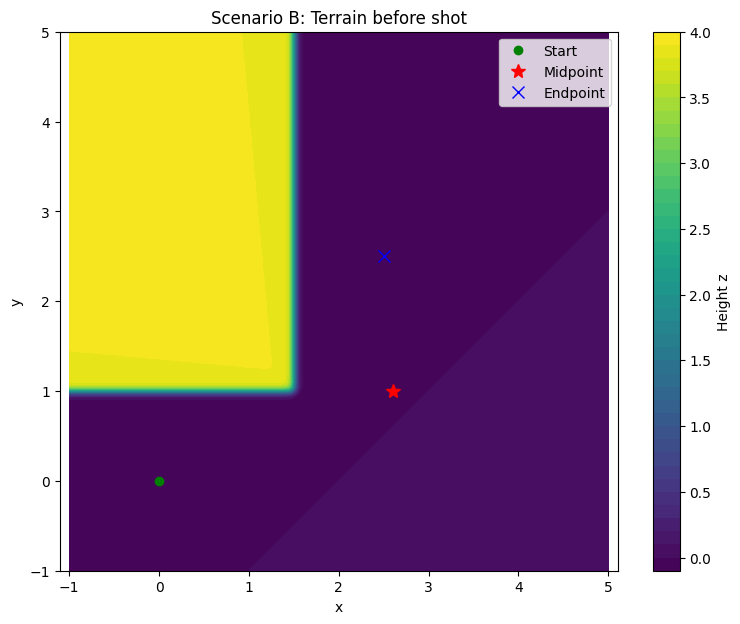

In [5]:
# Plot terrain for Scenario B before any shots
surface = ScenarioB()
x_range = np.linspace(-1, 5, 250)
y_range = np.linspace(-1, 5, 250)
X, Y = np.meshgrid(x_range, y_range)
Z = surface.height(X, Y)

plt.figure(figsize=(9, 7))
cs = plt.contourf(X, Y, Z, levels=40, cmap='viridis')
plt.colorbar(cs, label='Height z')
plt.title('Scenario B: Terrain before shot')
plt.xlabel('x')
plt.ylabel('y')
# Mark start, midpoint and endpoint (as in this scenario)
plt.plot(0, 0, 'go', label='Start')
plt.plot(2.6, 1.0, 'r*', markersize=10, label='Midpoint')
plt.plot(2.5, 2.5, 'bx', markersize=8, label='Endpoint')
plt.legend()
plt.axis('equal')
plt.show()

In [4]:
from scipy.optimize import least_squares
from scipy.integrate import solve_ivp

surface = ScenarioB()
physics = PhysicsEngine(surface)
solver = ShootingSolver(physics)

midpoint = np.array([2.6, 1.0])
endpoint = np.array([2.5, 2.5])

def objective_robust(params):
    vx0, vy0, T1, T2 = params
    # Soft penalty for invalid times -- guides the solver back to valid region
    if T1 <= 0.01 or T2 <= T1 + 0.01:
        return np.array([10.0, 10.0, 10.0, 10.0]) * (1 + abs(T1) + abs(T2))

    initial_state = [0, 0, vx0, vy0]
    sol = solve_ivp(physics.equations_of_motion, [0, T2], initial_state, rtol=1e-8, atol=1e-8, dense_output=True)

    if not sol.success:
        return np.array([10.0, 10.0, 10.0, 10.0])

    state_T1 = sol.sol(T1)
    state_T2 = sol.sol(T2)

    residuals = [
        state_T1[0] - midpoint[0],
        state_T1[1] - midpoint[1],
        state_T2[0] - endpoint[0],
        state_T2[1] - endpoint[1],
    ]
    return np.array(residuals)

# Initial guess: [vx, vy, T_midpoint, T_total]
guess = [2.5, 1.0, 1.5, 3.0]

# Bounds: vx, vy unbounded; Times must be (0.1, 10.0)
lower_bounds = [-np.inf, -np.inf, 0.1, 0.1]
upper_bounds = [np.inf, np.inf, 10.0, 10.0]

res = least_squares(objective_robust, guess, bounds=(lower_bounds, upper_bounds), method='trf')

print("Success:", res.success)
print("Solution:", res.x)
print("Cost:", res.cost)

if res.success:
    vx0, vy0, T1, T2 = res.x
    initial_state = [0, 0, vx0, vy0]
    # Integrate final solution for plotting using solve_ivp with t_eval for trajectory
    sol_final = solve_ivp(physics.equations_of_motion, [0, T2], initial_state, t_eval=np.linspace(0, T2, 500), rtol=1e-8, atol=1e-8)
    plot_trajectory(surface, sol_final, title="Scenario B Solution")

KeyboardInterrupt: 

In [ ]:
if res.success:
    vx0, vy0, T1, T2 = res.x
    initial_state = [0, 0, vx0, vy0]
    sol_path = solver.integrate(initial_state, [0, T2])
    plot_trajectory(surface, sol_path, title="Scenario B Solution")
    
    # Verify points
    from scipy.integrate import solve_ivp
    sol_dense = solve_ivp(
        physics.equations_of_motion,
        [0, T2],
        initial_state,
        rtol=1e-8, atol=1e-8,
        dense_output=True
    )
    p1 = sol_dense.sol(T1)
    p2 = sol_dense.sol(T2)
    print(f"Point at T1: ({p1[0]:.4f}, {p1[1]:.4f}) vs Target ({midpoint[0]}, {midpoint[1]})")
    print(f"Point at T2: ({p2[0]:.4f}, {p2[1]:.4f}) vs Target ({endpoint[0]}, {endpoint[1]})")